# Overview

Awhile ago, I chanced upon Chris Deotte's analysis at https://www.kaggle.com/c/tweet-sentiment-extraction/discussion/142404#809872. Found it interesting and since I had GPU to spare while training my models offline, I tried to replicate the process with Think deep.'s work at https://www.kaggle.com/seesee/faster-2x-tf-roberta. After modifying the CNN head a bit (don't ask me why, its part of my experiments), and attempting to replicate Chris' findings, I arrived at the below results in the historgram plots. In summary, the changes are:
- Modified CNN layers
- Varied seeds and performed repeated submissions and commits for same seeds

# Findings

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
lbs = [0.706] +  [0.707]*6 + [0.708]*5 + [0.709]*7 + [0.710]*8 + [0.711]*4 + [0.712]*8 + [0.713]*2 + [0.714]*2 + [0.715]*2
pp = plt.hist(lbs, bins=10)
plt.title("LB Scores")
plt.show()

And their corresponding estimated (rounded) mean 5-fold Jaccard scores are:

In [ ]:
jac = [0.708]*5 + [0.707]*9 + [0.706]*6 + [0.705]*12 + [0.704]*8 + [0.703]*2 + [0.702] + [0.701]*2
pp2 = plt.hist(jac, bins=8)
plt.title("Estimated (Rounded) Mean Jaccard Scores")
plt.show()

In [ ]:
print('Number of submissions above: ' + str(len(lbs)))

# Additional Findings & Suggestions

## The "Magical" Seed
I've tried various seeds, around 25-30 of them. There are about 5 seeds that gave me either consistently high LB scores or very wide LB ranges, for example 0.708 to 0.715. The seed used in this note book so far gave ranges between 0.709 and 0.715, and is not the "best" seed I've found, which consistently gave LB scores between 0.712 and 0.715 for this notebook. Feel free to try it out but honestly, you may be better off working on your model instead.

## Suggestions?
According to Ambitious at https://www.kaggle.com/c/tweet-sentiment-extraction/discussion/142404#809872, he states that "Actual LB score should be a little lower because you use early stopping on OOF folds. In order to truly replicate LB scores you should split train data into train and dev sets, train your models with cross-validation on train set and then evaluate on a dev set. Especially interesting would be to estimate influence of using different CV splits."

To-date, I've tried various splits and I found 10 splits to be the configuration that gave the most consistent CV and LB scores. For example, resubmission and rescorings of See-'s notebook (with some modifications) gave LB 0.710 9 out of 10 times. You may want to explore different splits, but if you lack the time to do so, perhaps sticking to 10 splits once you have a model with good Jaccard CVs will be best.

# Acknowledgements

- Built-upon See--'s notebook at https://www.kaggle.com/seesee/faster-2x-tf-roberta
- Many thanks to Chris Deotte for his TF roBERTa dataset at https://www.kaggle.com/cdeotte/tf-roberta

### The remaining majority of the notebook is from See--'s notebook above

# TensorFlow roBERTa with CNN Head
This notebook is a TensorFlow template for solving Kaggle's Tweet Sentiment Extraction competition as a question and answer roBERTa formulation. In this notebook, we show how to tokenize the data, create question answer targets, and how to build a custom question answer head for roBERTa in TensorFlow. Note that HuggingFace transformers don't have a `TFRobertaForQuestionAnswering` so we must make our own from `TFRobertaModel`. This notebook can achieve LB 0.715 with some modifications. Have fun experimenting!

You can also run this code offline and it will save the best model weights during each of the 5 folds of training. Upload those weights to a private Kaggle dataset and attach to this notebook. Then you can run this notebook with the line `model.fit()` commented out, and this notebook will instead load your offline models. It will use your offline models to predict oof and predict test. Hence this notebook can easily be converted to an inference notebook. An inference notebook is advantageous because it will only take 10 minutes to commit and submit instead of 2 hours. Better to train 2 hours offline separately.

# Load Libraries, Data, Tokenizer
We will use HuggingFace transformers [here][1]

[1]: https://huggingface.co/transformers/

In [ ]:
import pandas as pd, numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
from sklearn.model_selection import StratifiedKFold
from transformers import *
import tokenizers
import math
print('TF version',tf.__version__)

In [ ]:
MAX_LEN = 96
PATH = '../input/tf-roberta/'
tokenizer = tokenizers.ByteLevelBPETokenizer(
    vocab_file=PATH+'vocab-roberta-base.json', 
    merges_file=PATH+'merges-roberta-base.txt', 
    lowercase=True,
    add_prefix_space=True
)
EPOCHS = 3 # originally 3
BATCH_SIZE = 32 # originally 32
PAD_ID = 1
SEED = 88888
LABEL_SMOOTHING = 0.1
tf.random.set_seed(SEED)
np.random.seed(SEED)
sentiment_id = {'positive': 1313, 'negative': 2430, 'neutral': 7974}
train = pd.read_csv('../input/tweet-sentiment-extraction/train.csv').fillna('')
train.head()

# Training Data
We will now convert the training data into arrays that roBERTa understands. Here are example inputs and targets: 
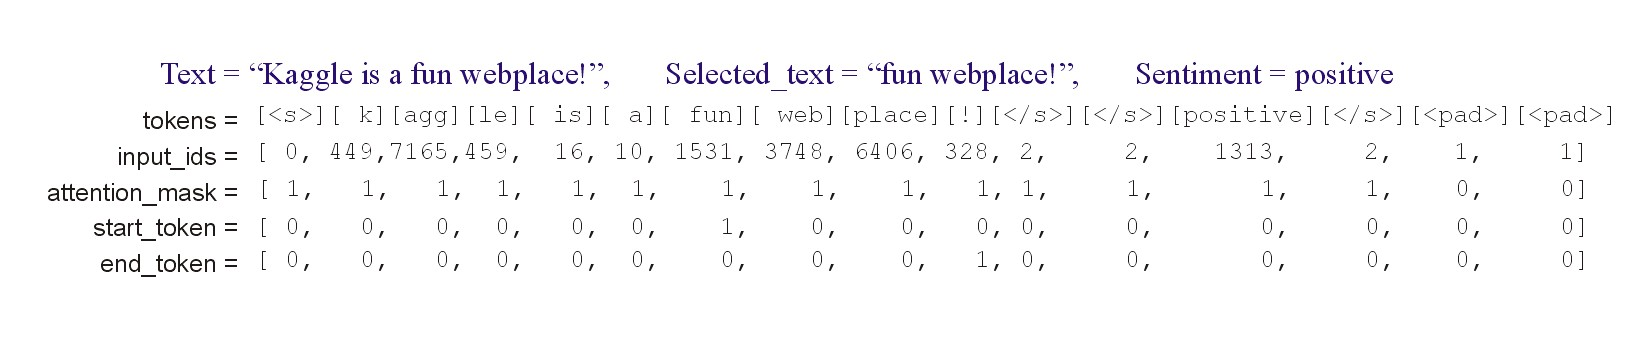
The tokenization logic below is inspired by Abhishek's PyTorch notebook [here][1].

[1]: https://www.kaggle.com/abhishek/roberta-inference-5-folds

In [ ]:
ct = train.shape[0]
input_ids = np.ones((ct,MAX_LEN),dtype='int32')
attention_mask = np.zeros((ct,MAX_LEN),dtype='int32')
token_type_ids = np.zeros((ct,MAX_LEN),dtype='int32')
start_tokens = np.zeros((ct,MAX_LEN),dtype='int32')
end_tokens = np.zeros((ct,MAX_LEN),dtype='int32')

for k in range(train.shape[0]):
    
    # FIND OVERLAP
    text1 = " "+" ".join(train.loc[k,'text'].split())
    text2 = " ".join(train.loc[k,'selected_text'].split())
    idx = text1.find(text2)
    chars = np.zeros((len(text1)))
    chars[idx:idx+len(text2)]=1
    if text1[idx-1]==' ': chars[idx-1] = 1 
    enc = tokenizer.encode(text1) 
        
    # ID_OFFSETS
    offsets = []; idx=0
    for t in enc.ids:
        w = tokenizer.decode([t])
        offsets.append((idx,idx+len(w)))
        idx += len(w)
    
    # START END TOKENS
    toks = []
    for i,(a,b) in enumerate(offsets):
        sm = np.sum(chars[a:b])
        if sm>0: toks.append(i) 
        
    s_tok = sentiment_id[train.loc[k,'sentiment']]
    input_ids[k,:len(enc.ids)+3] = [0, s_tok] + enc.ids + [2]
    attention_mask[k,:len(enc.ids)+3] = 1
    if len(toks)>0:
        start_tokens[k,toks[0]+2] = 1
        end_tokens[k,toks[-1]+2] = 1

# Test Data
We must tokenize the test data exactly the same as we tokenize the training data

In [ ]:
test = pd.read_csv('../input/tweet-sentiment-extraction/test.csv').fillna('')

ct = test.shape[0]
input_ids_t = np.ones((ct,MAX_LEN),dtype='int32')
attention_mask_t = np.zeros((ct,MAX_LEN),dtype='int32')
token_type_ids_t = np.zeros((ct,MAX_LEN),dtype='int32')

for k in range(test.shape[0]):
        
    # INPUT_IDS
    text1 = " "+" ".join(test.loc[k,'text'].split())
    enc = tokenizer.encode(text1)                
    s_tok = sentiment_id[test.loc[k,'sentiment']]
    input_ids_t[k,:len(enc.ids)+3] = [0, s_tok] + enc.ids + [2]
    attention_mask_t[k,:len(enc.ids)+3] = 1

# Build roBERTa Model
We use a pretrained roBERTa base model and add a custom question answer head. First tokens are input into `bert_model` and we use BERT's first output, i.e. `x[0]` below. These are embeddings of all input tokens and have shape `(batch_size, MAX_LEN, 768)`. Next we apply `tf.keras.layers.Conv1D(filters=1, kernel_size=1)` and transform the embeddings into shape `(batch_size, MAX_LEN, 1)`. We then flatten this and apply `softmax`, so our final output from `x1` has shape `(batch_size, MAX_LEN)`. These are one hot encodings of the start tokens indicies (for `selected_text`). And `x2` are the end tokens indicies.

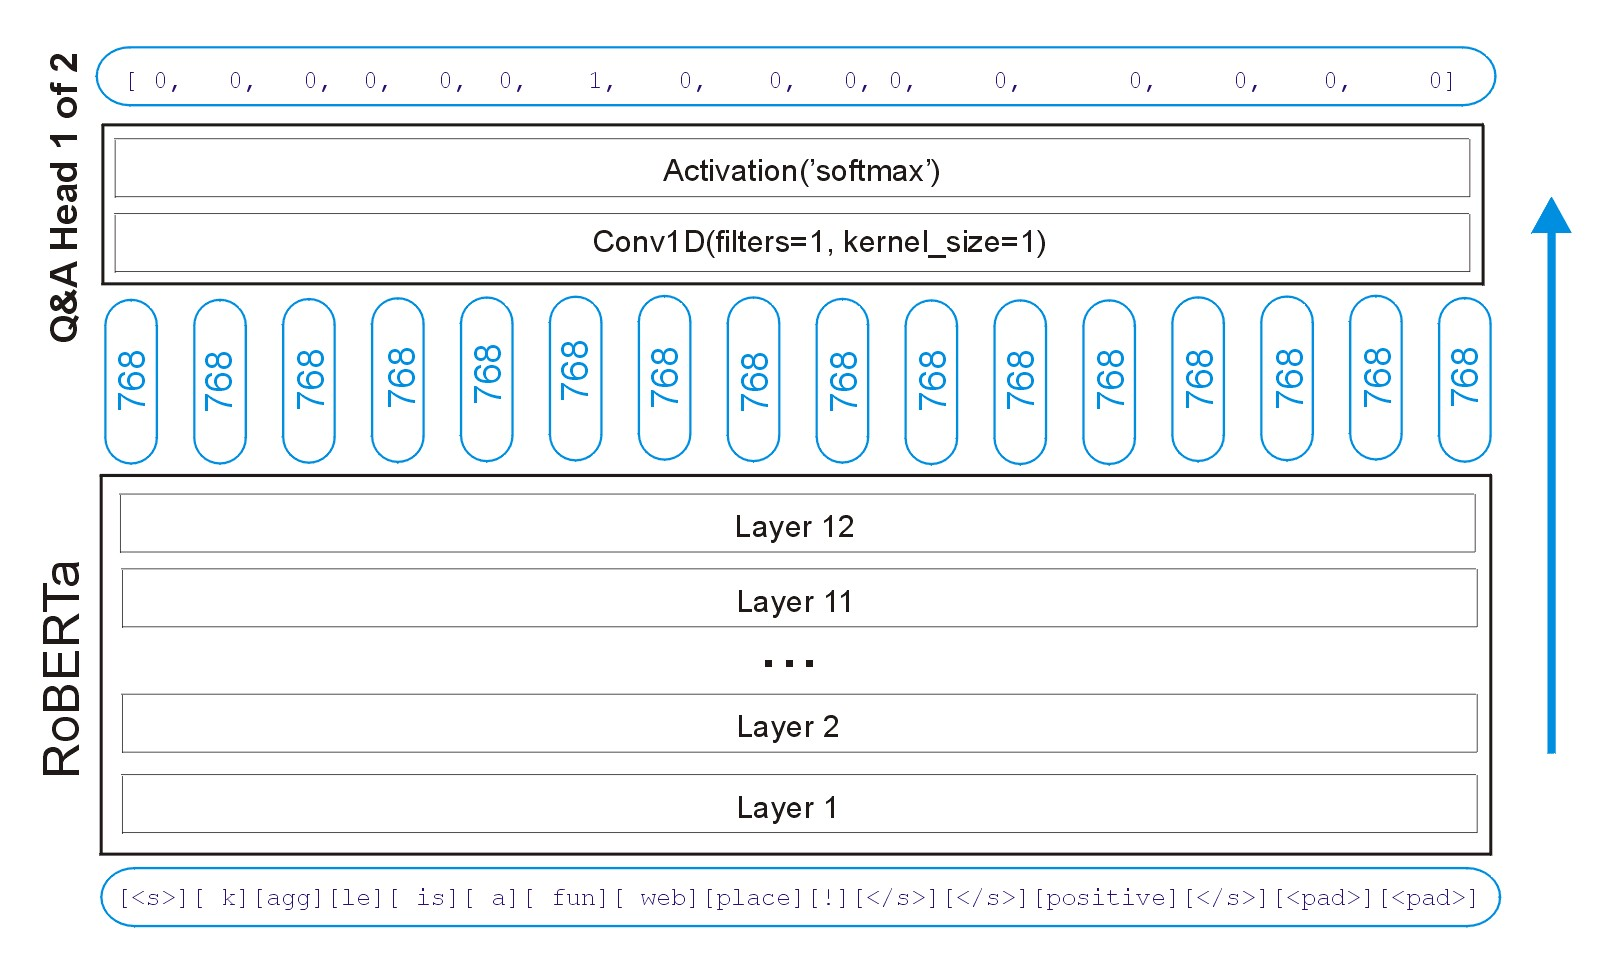

In [ ]:
import pickle

def save_weights(model, dst_fn):
    weights = model.get_weights()
    with open(dst_fn, 'wb') as f:
        pickle.dump(weights, f)


def load_weights(model, weight_fn):
    with open(weight_fn, 'rb') as f:
        weights = pickle.load(f)
    model.set_weights(weights)
    return model

def loss_fn(y_true, y_pred):
    # adjust the targets for sequence bucketing
    ll = tf.shape(y_pred)[1]
    y_true = y_true[:, :ll]
    loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred,
        from_logits=False, label_smoothing=LABEL_SMOOTHING)
    loss = tf.reduce_mean(loss)
    return loss


def build_model():
    ids = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)
    att = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)
    tok = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)
    padding = tf.cast(tf.equal(ids, PAD_ID), tf.int32)

    lens = MAX_LEN - tf.reduce_sum(padding, -1)
    max_len = tf.reduce_max(lens)
    ids_ = ids[:, :max_len]
    att_ = att[:, :max_len]
    tok_ = tok[:, :max_len]

    config = RobertaConfig.from_pretrained(PATH+'config-roberta-base.json')
    bert_model = TFRobertaModel.from_pretrained(PATH+'pretrained-roberta-base.h5',config=config)
    x = bert_model(ids_,attention_mask=att_,token_type_ids=tok_)
    
    x1 = tf.keras.layers.Dropout(0.1)(x[0])
    x1 = tf.keras.layers.Conv1D(768, 2,padding='same')(x1)
    x1 = tf.keras.layers.LeakyReLU()(x1)
    x1 = tf.keras.layers.Dense(1)(x1)
    x1 = tf.keras.layers.Flatten()(x1)
    x1 = tf.keras.layers.Activation('softmax')(x1)
    
    x2 = tf.keras.layers.Dropout(0.1)(x[0]) 
    x2 = tf.keras.layers.Conv1D(768, 2,padding='same')(x2)
    x2 = tf.keras.layers.LeakyReLU()(x2)
    x2 = tf.keras.layers.Dense(1)(x2)
    x2 = tf.keras.layers.Flatten()(x2)
    x2 = tf.keras.layers.Activation('softmax')(x2)

    model = tf.keras.models.Model(inputs=[ids, att, tok], outputs=[x1,x2])
    optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5) 
    model.compile(loss=loss_fn, optimizer=optimizer)
    
    # this is required as `model.predict` needs a fixed size!
    x1_padded = tf.pad(x1, [[0, 0], [0, MAX_LEN - max_len]], constant_values=0.)
    x2_padded = tf.pad(x2, [[0, 0], [0, MAX_LEN - max_len]], constant_values=0.)
    
    padded_model = tf.keras.models.Model(inputs=[ids, att, tok], outputs=[x1_padded,x2_padded])
    return model, padded_model

# Metric

In [ ]:
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    if (len(a)==0) & (len(b)==0): return 0.5
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

# Train roBERTa Model
We train with 5 Stratified KFolds (based on sentiment stratification). Each fold, the best model weights are saved and then reloaded before oof prediction and test prediction. Therefore you can run this code offline and upload your 5 fold models to a private Kaggle dataset. Then run this notebook and comment out the line `model.fit()`. Instead your notebook will load your model weights from offline training in the line `model.load_weights()`. Update this to have the correct path. Also make sure you change the KFold seed below to match your offline training. Then this notebook will proceed to use your offline models to predict oof and predict test.

In [ ]:
jac = []; VER='v0'; DISPLAY=1 # USE display=1 FOR INTERACTIVE
oof_start = np.zeros((input_ids.shape[0],MAX_LEN))
oof_end = np.zeros((input_ids.shape[0],MAX_LEN))
preds_start = np.zeros((input_ids_t.shape[0],MAX_LEN))
preds_end = np.zeros((input_ids_t.shape[0],MAX_LEN))

skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=SEED) #originally 5 splits
for fold,(idxT,idxV) in enumerate(skf.split(input_ids,train.sentiment.values)):

    print('#'*25)
    print('### FOLD %i'%(fold+1))
    print('#'*25)
    
    K.clear_session()
    model, padded_model = build_model()
        
    #sv = tf.keras.callbacks.ModelCheckpoint(
    #    '%s-roberta-%i.h5'%(VER,fold), monitor='val_loss', verbose=1, save_best_only=True,
    #    save_weights_only=True, mode='auto', save_freq='epoch')
    inpT = [input_ids[idxT,], attention_mask[idxT,], token_type_ids[idxT,]]
    targetT = [start_tokens[idxT,], end_tokens[idxT,]]
    inpV = [input_ids[idxV,],attention_mask[idxV,],token_type_ids[idxV,]]
    targetV = [start_tokens[idxV,], end_tokens[idxV,]]
    # sort the validation data
    shuffleV = np.int32(sorted(range(len(inpV[0])), key=lambda k: (inpV[0][k] == PAD_ID).sum(), reverse=True))
    inpV = [arr[shuffleV] for arr in inpV]
    targetV = [arr[shuffleV] for arr in targetV]
    weight_fn = '%s-roberta-%i.h5'%(VER,fold)
    for epoch in range(1, EPOCHS + 1):
        # sort and shuffle: We add random numbers to not have the same order in each epoch
        shuffleT = np.int32(sorted(range(len(inpT[0])), key=lambda k: (inpT[0][k] == PAD_ID).sum() + np.random.randint(-3, 3), reverse=True))
        # shuffle in batches, otherwise short batches will always come in the beginning of each epoch
        num_batches = math.ceil(len(shuffleT) / BATCH_SIZE)
        batch_inds = np.random.permutation(num_batches)
        shuffleT_ = []
        for batch_ind in batch_inds:
            shuffleT_.append(shuffleT[batch_ind * BATCH_SIZE: (batch_ind + 1) * BATCH_SIZE])
        shuffleT = np.concatenate(shuffleT_)
        # reorder the input data
        inpT = [arr[shuffleT] for arr in inpT]
        targetT = [arr[shuffleT] for arr in targetT]
        model.fit(inpT, targetT, 
            epochs=epoch, initial_epoch=epoch - 1, batch_size=BATCH_SIZE, verbose=DISPLAY, callbacks=[],
            validation_data=(inpV, targetV), shuffle=False)  # don't shuffle in `fit`
        save_weights(model, weight_fn)

    print('Loading model...')
    # model.load_weights('%s-roberta-%i.h5'%(VER,fold))
    load_weights(model, weight_fn)

    print('Predicting OOF...')
    oof_start[idxV,],oof_end[idxV,] = padded_model.predict([input_ids[idxV,],attention_mask[idxV,],token_type_ids[idxV,]],verbose=DISPLAY)
    
    print('Predicting Test...')
    preds = padded_model.predict([input_ids_t,attention_mask_t,token_type_ids_t],verbose=DISPLAY)
    preds_start += preds[0]/skf.n_splits
    preds_end += preds[1]/skf.n_splits
    
    # DISPLAY FOLD JACCARD
    all = []
    for k in idxV:
        a = np.argmax(oof_start[k,])
        b = np.argmax(oof_end[k,])
        if a>b: 
            st = train.loc[k,'text'] # IMPROVE CV/LB with better choice here
        else:
            text1 = " "+" ".join(train.loc[k,'text'].split())
            enc = tokenizer.encode(text1)
            st = tokenizer.decode(enc.ids[a-2:b-1])
        all.append(jaccard(st,train.loc[k,'selected_text']))
    jac.append(np.mean(all))
    print('>>>> FOLD %i Jaccard ='%(fold+1),np.mean(all))
    print()

In [ ]:
print('>>>> OVERALL 5Fold CV Jaccard =',np.mean(jac))

In [ ]:
print(jac) # Jaccard CVs

# Kaggle Submission

In [ ]:
all = []
for k in range(input_ids_t.shape[0]):
    a = np.argmax(preds_start[k,])
    b = np.argmax(preds_end[k,])
    if a>b: 
        st = test.loc[k,'text']
    else:
        text1 = " "+" ".join(test.loc[k,'text'].split())
        enc = tokenizer.encode(text1)
        st = tokenizer.decode(enc.ids[a-2:b-1])
    all.append(st)

In [ ]:
test['selected_text'] = all
test[['textID','selected_text']].to_csv('submission.csv',index=False)
pd.set_option('max_colwidth', 60)
test.sample(25)

## That's all for now, all the best and happy Kaggling!